# Arquitecturas de prueba para imágenes renales

Se implementarán las arquitecturas para las redes neuronales convolucionales orientadas al análisis de imágenes de biopsias renales. Se presenta el uso de las siguientes arquitecturas subrayadas:

- U-Net
- V-Net (Variante de U-Net con convoluciones 3D)
- ***SegNet (Basado en autoencoders)***
- DeepLabV3+ (Para segmentación de alta precisión)
- Attention U-Net (Mejora la U-Net con atención)
- Mask R-CNN (Segmentación basada en detección)
- ResUNet (Combinación de U-Net y ResNet)
- ***PSPNet (Utiliza pirámides de pooling)***
- FCN (Fully Convolutional Networks)
- ***Swin UNet (Basado en Transformers)***

```{admonition} Redes Neuronales Convolucionales (RNC)

```

```{admonition} Redes Neuronales Convolucionales (CNN)
Son un tipo de red neuronal diseñada para procesar datos con una estructura de tipo grid, como imágenes, mediante la aplicación de filtros convolucionales que detectan patrones y características en diferentes niveles de abstracción.
```

## Librerías, paquetes y GPU necesarios

In [52]:
# %pip install opencv-python
import numpy as np
import pandas as pd
import os
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img
from tensorflow.keras.models import Model
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPool2D, Flatten
from tensorflow.keras.layers import Input, MaxPooling2D, UpSampling2D
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.utils import plot_model, to_categorical
from sklearn.metrics import roc_auc_score, jaccard_score, precision_score, recall_score, balanced_accuracy_score
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from keras.callbacks import ModelCheckpoint,EarlyStopping
from sklearn.model_selection import train_test_split
import datetime
from keras import regularizers
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2


#### Verificación de GPU's

In [30]:
devices = tf.config.list_physical_devices()
print("Available devices:")
for device in devices:
    print(device)

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print("TensorFlow is using GPU.")
    for gpu in gpus:
        gpu_details = tf.config.experimental.get_device_details(gpu)
        print(f"GPU details: {gpu_details}")
else:
    print("TensorFlow is not using GPU.")

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
TensorFlow is using GPU.
GPU details: {'device_name': 'NVIDIA GeForce RTX 2050', 'compute_capability': (8, 6)}


In [ ]:
print("GPUs detectadas:", len(tf.config.list_physical_devices('GPU')))
print("Dispositivos disponibles:")
print(tf.config.list_physical_devices())
print("GPU usada por defecto:")
print(tf.config.experimental.list_physical_devices('GPU'))


GPUs detectadas: 1
Dispositivos disponibles:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
GPU usada por defecto:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [ ]:
print(tf.sysconfig.get_build_info())

OrderedDict([('cpu_compiler', 'C:/Program Files (x86)/Microsoft Visual Studio/2019/Community/VC/Tools/MSVC/14.29.30133/bin/HostX64/x64/cl.exe'), ('cuda_compute_capabilities', ['sm_35', 'sm_50', 'sm_60', 'sm_70', 'sm_75', 'compute_80']), ('cuda_version', '64_112'), ('cudart_dll_name', 'cudart64_112.dll'), ('cudnn_dll_name', 'cudnn64_8.dll'), ('cudnn_version', '64_8'), ('is_cuda_build', True), ('is_rocm_build', False), ('is_tensorrt_build', False), ('msvcp_dll_names', 'msvcp140.dll,msvcp140_1.dll'), ('nvcuda_dll_name', 'nvcuda.dll')])


## Imágenes y máscaras a usar

Se cargan todas la imágenes en esta sección, sin embargo para probar la arquitectura se seleccionarán posteriormente solo 5 imágenes.

In [23]:
data_path1 = r"C:\Users\henry\Documents\jbook\parcial1_dl\datos\train_filter"
data_path2 = r"C:\Users\henry\Documents\jbook\parcial1_dl\datos\mascaras_guardadas"
image_dir = os.path.join(data_path1, 'train_filter')
mask_dir = os.path.join(data_path2, 'mascaras_guardadas')

In [24]:
# Obtenemos la lista de archivos de imagen y máscara
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('tif')])
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('tif')])

In [25]:
# Función para cargar imágenes y máscaras
def cargar_imagenes_y_mascaras(image_path, mask_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    return image, mask

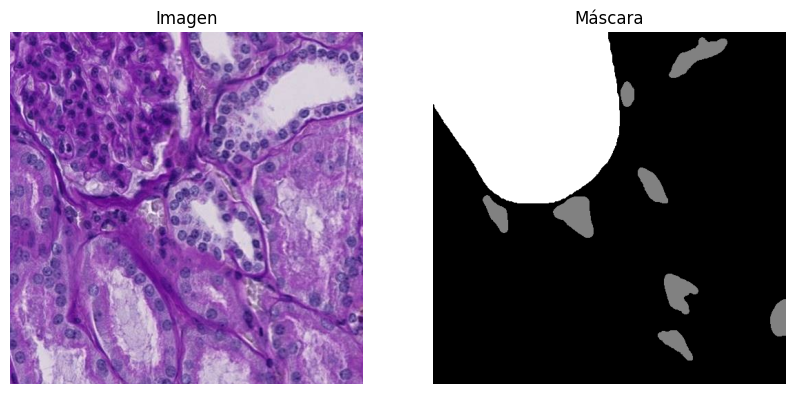

In [29]:
# Cargar y visualizar una imagen de prueba
idx = 0  # Índice de la imagen a visualizar
image_path = os.path.join(image_dir, image_files[idx])
mask_path = os.path.join(mask_dir, mask_files[idx])

image, mask = cargar_imagenes_y_mascaras(image_path, mask_path)

# Mostrar la imagen y su máscara
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(image)
ax[0].set_title("Imagen")
ax[0].axis("off")
ax[1].imshow(mask, cmap="gray")
ax[1].set_title("Máscara")
ax[1].axis("off")
plt.show()

## Implementación de arquitecturas neuronales

### SegNet - Basado en autoecoders

```{} ¿Qué es SegNet?
SegNet es una red neuronal convolucional (CNN) diseñada para la segmentación semántica de imágenes, lo que significa que asigna una etiqueta a cada píxel de la imagen de entrada. Se basa en un autoencoder convolucional con una arquitectura encoder-decoder.
```

#### Arquitectura de SegNet

- **Encoder**: Basado en VGG16, extrae características con capas convolucionales y de pooling.

- **Decoder**: Reconstruye la imagen de segmentación utilizando unpooling en lugar de upsampling tradicional, lo que mejora la preservación de bordes y detalles finos.

- **Softmax**: Produce un mapa de segmentación con probabilidades para cada clase.

![Descripción de la aequitectura SegNet](Arquitecturas/SegNet_Architecture_Ilustration.png)


Kanery le agregas la fuente

#### Preprocesamiento de las imágenes

Se seleccionan solo 5 de las imágenes y máscaras.

In [ ]:
# Obtener lista de archivos de imágenes y máscaras (solo 5 imágenes)
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('tif')])[:5]
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('tif')])[:5]

In [34]:
# Función para cargar imágenes y máscaras
def cargar_imagenes_y_mascaras(image_path, mask_path):
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Convertir a RGB
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)  # Escala de grises
    return image, mask

In [35]:
def preprocesar_imagen(image, mask):
    image = image / 255.0  # Normalizar la imagen RGB
    mask = mask / 255.0  # Normalizar la máscara - si es binaria queda entre [0 y 1]
    mask = np.expand_dims(mask, axis=-1)  # Añadir canal de profundidad
    return image, mask

Observamos las imágenes y sus dimensiones.

In [32]:
print("Dimensiones de la imagen:", image.shape)

Dimensiones de la imagen: (512, 512, 3)


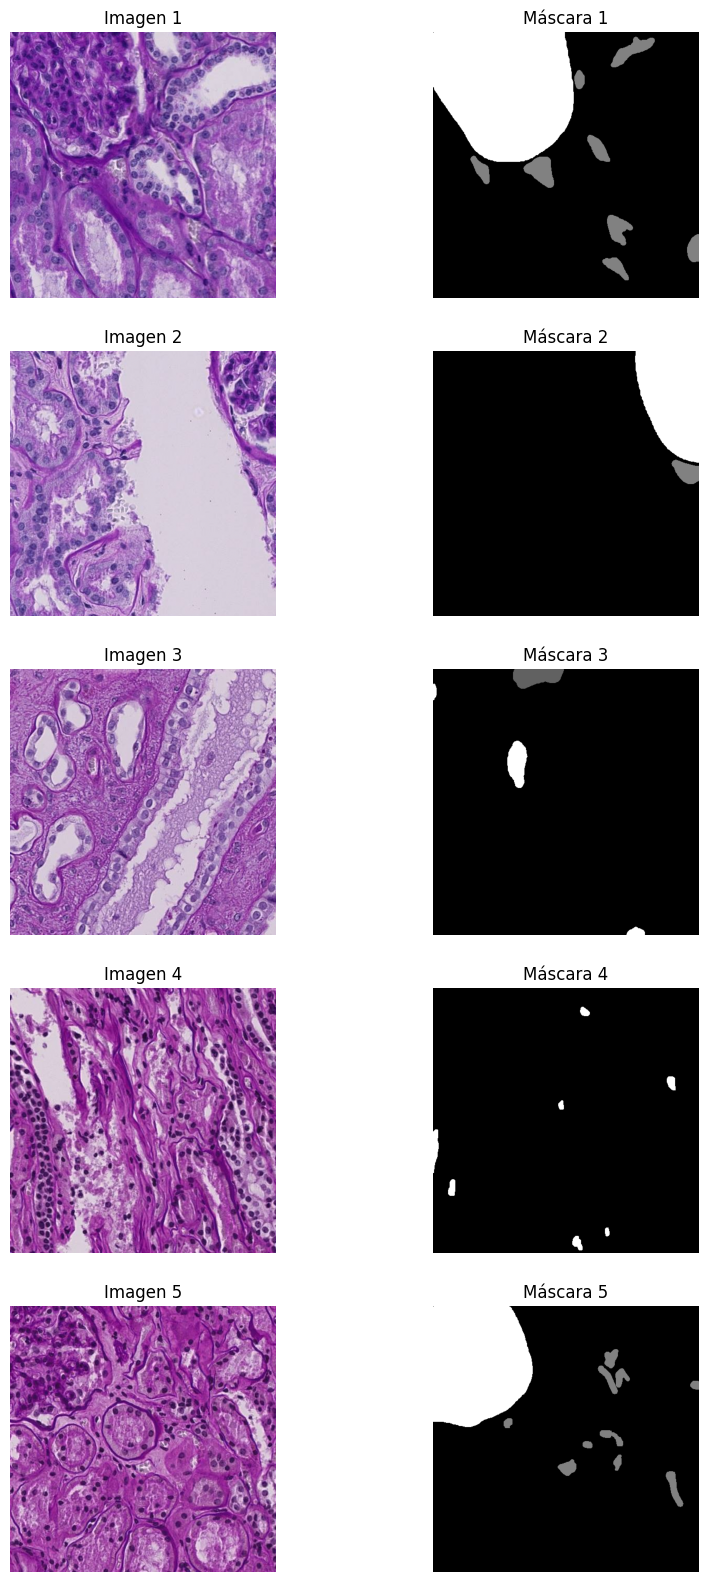

In [36]:
fig, axes = plt.subplots(5, 2, figsize=(10, 20))
for idx in range(5):
    image_path = os.path.join(image_dir, image_files[idx])
    mask_path = os.path.join(mask_dir, mask_files[idx])
    
    image, mask = cargar_imagenes_y_mascaras(image_path, mask_path)
    image, mask = preprocesar_imagen(image, mask)
    
    axes[idx, 0].imshow(image)
    axes[idx, 0].set_title(f"Imagen {idx+1}")
    axes[idx, 0].axis("off")
    
    axes[idx, 1].imshow(mask.squeeze(), cmap="gray")
    axes[idx, 1].set_title(f"Máscara {idx+1}")
    axes[idx, 1].axis("off")

### Construcción de la arquitectura

In [42]:
def build_segnet(input_shape = (512, 512, 3), num_classes = 2):
    inputs = Input(shape = input_shape)
    
    # Encoder
    x = Conv2D(64, (3, 3), padding = 'same')(inputs)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2,2), strides =(2,2), name= 'pool1')(x)
    
    x = Conv2D(128, (3, 3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides = (2, 2), name = 'pool2')(x)
    
    x = Conv2D(256, (3, 3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D((2, 2), strides=(2, 2), name = 'pool3')(x)
    
    #Decoder
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(256, (3, 3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(128, (3, 3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(64, (3, 3), padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    outputs = Conv2D(num_classes, (1, 1), activation = 'softmax')(x)
    
    model = Model(inputs, outputs)
    return model

    

In [43]:
# Constriur el modelo
segnet_model = build_segnet()
segnet_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_2 (Conv2D)           (None, 512, 512, 64)      1792      
                                                                 
 batch_normalization_2 (Batc  (None, 512, 512, 64)     256       
 hNormalization)                                                 
                                                                 
 activation_2 (Activation)   (None, 512, 512, 64)      0         
                                                                 
 pool1 (MaxPooling2D)        (None, 256, 256, 64)      0         
                                                                 
 conv2d_3 (Conv2D)           (None, 256, 256, 128)     73856     
                                                             

In [46]:
# Plot model structure
plot_model(segnet_model, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


Ejecutar el modelo

In [49]:
def cargar_datos(image_dir, mask_dir, image_files, mask_files, target_size=(512, 512), num_classes=2):
    images, masks = [], []
    for img_name, mask_name in zip(image_files, mask_files):
        # Cargar imagen
        img = cv2.imread(os.path.join(image_dir, img_name))
        img = cv2.resize(img, target_size) / 255.0  # Normalizar
        images.append(img)

        # Cargar máscara en escala de grises
        mask = cv2.imread(os.path.join(mask_dir, mask_name), 0)
        mask = cv2.resize(mask, target_size, interpolation=cv2.INTER_NEAREST)  # Mantener etiquetas discretas
        mask = mask / 255.0  # Normalizar a [0,1]

        # One-hot encoding si hay más de 2 clases
        if num_classes > 2:
            mask = to_categorical(mask, num_classes=num_classes)

        masks.append(mask)

    return np.array(images), np.array(masks)

In [75]:
# Cargar datos de entrenamiento y validación
images, masks = cargar_datos(image_dir, mask_dir, image_files, mask_files)
# Convertir máscaras a formato categórico si hay más de 2 clases
masks = to_categorical(masks, num_classes=2)

In [76]:
# División en entrenamiento y validación
train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=42)


In [77]:
# Construcción y compilación del modelo
segnet_model = build_segnet()
segnet_model.compile(optimizer=Adam(learning_rate=1e-4), loss=CategoricalCrossentropy(), metrics=['accuracy'])


In [72]:
# Visualizar estructura del modelo
plot_model(segnet_model, to_file='model_cnn.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [59]:
# Entrenamiento del modelo

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = segnet_model.fit(train_images, train_masks, 
                           validation_data=(val_images, val_masks), 
                           batch_size=1, epochs=50, verbose=2, 
                           callbacks=[early_stopping])

Epoch 1/50
4/4 - 89s - loss: 0.4603 - accuracy: 0.8245 - val_loss: 0.6782 - val_accuracy: 1.0000 - 89s/epoch - 22s/step
Epoch 2/50
4/4 - 1s - loss: 0.3870 - accuracy: 0.9137 - val_loss: 0.6677 - val_accuracy: 1.0000 - 1s/epoch - 262ms/step
Epoch 3/50
4/4 - 1s - loss: 0.3338 - accuracy: 0.9706 - val_loss: 0.6459 - val_accuracy: 1.0000 - 1s/epoch - 260ms/step
Epoch 4/50
4/4 - 1s - loss: 0.2847 - accuracy: 0.9897 - val_loss: 0.6275 - val_accuracy: 1.0000 - 1s/epoch - 265ms/step
Epoch 5/50
4/4 - 1s - loss: 0.2383 - accuracy: 0.9977 - val_loss: 0.6150 - val_accuracy: 1.0000 - 1s/epoch - 256ms/step
Epoch 6/50
4/4 - 1s - loss: 0.2002 - accuracy: 0.9985 - val_loss: 0.6026 - val_accuracy: 1.0000 - 1s/epoch - 258ms/step
Epoch 7/50
4/4 - 1s - loss: 0.1692 - accuracy: 0.9994 - val_loss: 0.5819 - val_accuracy: 1.0000 - 1s/epoch - 287ms/step
Epoch 8/50
4/4 - 1s - loss: 0.1463 - accuracy: 0.9997 - val_loss: 0.5603 - val_accuracy: 1.0000 - 1s/epoch - 281ms/step
Epoch 9/50
4/4 - 1s - loss: 0.1284 - acc

In [60]:
# Predicciones
val_preds = segnet_model.predict(val_images)
val_preds = np.argmax(val_preds, axis=-1)
val_masks_flat = np.argmax(val_masks, axis=-1)

1/1 [==============================] - 0s 213ms/step


Métricas

In [ ]:
# Kanery esta no la uses
# # Calcular métricas de segmentación
dice = 2 * np.sum(val_preds * val_masks_flat) / (np.sum(val_preds) + np.sum(val_masks_flat) + 1e-7)
iou = jaccard_score(val_masks_flat.flatten(), val_preds.flatten(), average='macro')
precision = precision_score(val_masks_flat.flatten(), val_preds.flatten(), average='macro')
recall = recall_score(val_masks_flat.flatten(), val_preds.flatten(), average='macro')


In [ ]:
# usa esta y la de abajo
# Calcular métricas
dice = 2 * np.sum(val_preds * val_masks_flat) / (np.sum(val_preds) + np.sum(val_masks_flat) + 1e-7)
iou = jaccard_score(val_masks_flat.flatten(), val_preds.flatten(), average='macro')
precision = precision_score(val_masks_flat.flatten(), val_preds.flatten(), average='macro')
recall = recall_score(val_masks_flat.flatten(), val_preds.flatten(), average='macro')
auc = roc_auc_score(val_masks_flat.flatten(), val_preds.flatten(), average='macro')
balanced_acc = balanced_accuracy_score(val_masks_flat.flatten(), val_preds.flatten())


In [68]:
# Función de Hausdorff Distance
def hausdorff_distance(pred, mask):
    pred_points = np.argwhere(pred)
    mask_points = np.argwhere(mask)
    if len(pred_points) == 0 or len(mask_points) == 0:
        return np.nan
    dist1 = np.max([np.min(np.linalg.norm(pred_point - mask_points, axis=1)) for pred_point in pred_points])
    dist2 = np.max([np.min(np.linalg.norm(mask_point - pred_points, axis=1)) for mask_point in mask_points])
    return max(dist1, dist2)

hausdorff = hausdorff_distance(val_preds, val_masks_flat)


In [81]:
# Tabla resumen
metrics_df = pd.DataFrame({
    "Model": ["SegNet"],
    "Dice Coefficient": [dice],
    "IoU": [iou],
    "Precision": [precision],
    "Recall": [recall],
    "AUC": [auc],
    "Hausdorff Distance": [hausdorff],
    "Balanced Accuracy": [balanced_acc]
})


In [70]:
print(metrics_df)

    Model  Dice Coefficient  IoU  Precision  Recall  AUC  Hausdorff Distance  \
0  SegNet               0.0  1.0        1.0     1.0  NaN                 NaN   

   Balanced Accuracy  
0                1.0  


mas imagenes

In [71]:
image_files = sorted([f for f in os.listdir(image_dir) if f.endswith('tif')])[:50]
mask_files = sorted([f for f in os.listdir(mask_dir) if f.endswith('tif')])[:50]

In [78]:

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

history = segnet_model.fit(train_images, train_masks, 
                           validation_data=(val_images, val_masks), 
                           batch_size=1, epochs=50, verbose=2, 
                           callbacks=[early_stopping])

Epoch 1/50
40/40 - 11s - loss: 0.2952 - accuracy: 0.9559 - val_loss: 0.4571 - val_accuracy: 1.0000 - 11s/epoch - 282ms/step
Epoch 2/50
40/40 - 10s - loss: 0.1235 - accuracy: 0.9999 - val_loss: 0.2324 - val_accuracy: 1.0000 - 10s/epoch - 245ms/step
Epoch 3/50
40/40 - 10s - loss: 0.0667 - accuracy: 1.0000 - val_loss: 0.1486 - val_accuracy: 1.0000 - 10s/epoch - 250ms/step
Epoch 4/50
40/40 - 10s - loss: 0.0507 - accuracy: 1.0000 - val_loss: 0.1072 - val_accuracy: 1.0000 - 10s/epoch - 244ms/step
Epoch 5/50
40/40 - 10s - loss: 0.0431 - accuracy: 1.0000 - val_loss: 0.0858 - val_accuracy: 1.0000 - 10s/epoch - 247ms/step
Epoch 6/50
40/40 - 10s - loss: 0.0378 - accuracy: 1.0000 - val_loss: 0.0653 - val_accuracy: 1.0000 - 10s/epoch - 244ms/step
Epoch 7/50
40/40 - 10s - loss: 0.0340 - accuracy: 1.0000 - val_loss: 0.0549 - val_accuracy: 1.0000 - 10s/epoch - 244ms/step
Epoch 8/50
40/40 - 10s - loss: 0.0308 - accuracy: 1.0000 - val_loss: 0.0470 - val_accuracy: 1.0000 - 10s/epoch - 243ms/step
Epoch 9/

In [80]:
# Predicciones
val_preds = segnet_model.predict(val_images, batch_size=1)  # Reduce batch size to 1
val_preds = np.argmax(val_preds, axis=-1)
val_masks_flat = np.argmax(val_masks, axis=-1)

10/10 [==============================] - 1s 86ms/step


In [82]:
print(metrics_df)

    Model  Dice Coefficient  IoU  Precision  Recall  AUC  Hausdorff Distance  \
0  SegNet               0.0  1.0        1.0     1.0  NaN                 NaN   

   Balanced Accuracy  
0                1.0  


### PSPNet - Pirámides de Pooling